# **epileptic seizures detection in EEG signals**

### **ABSTRAT**
##### Epilepsy, a brain disease generally associated with seizures, has tremendous effects on people’s quality of life. Diagnosis of epileptic seizures is commonly performed on electroencephalography (EEG) signals, and by using computer-aided diagnosis systems (CADS), neurologists can diagnose epileptic seizure stages more accurately.

##### In these systems, a mandatory stage is feature extraction, performed by handcrafting features or learning them, ordinarily by a deep neural net. While researches in this field commonly show the value of a group of limited features, yet an accurate comparison between different suggested features is essential.

##### in this notebook we will:
  1. extract more than *15* features from these categories :
     - Time Domain
     - Frequency Domain

  2. running *SVM*, *Random forest* and	*KNN* using k-fold cross validation on:
     - signals 
     - feature
     
     and calculating *Accuracy*, *Precision* and *Recall* for the models.
     
  3. finding best *hyperparameter* for each algorithm and plot:
     - Confusion Matrix 
     - Receiver Operating Characteristic

     for models with best Hyperparameter
  4. check how mush *Normalization* helped us to make better model



## Imports

In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter
from sklearn.svm import SVC

import random
import os
# my imports#############################
import scipy.stats as stats
from matplotlib import pyplot as plt
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

## setting seed
we set seed as a constant. The goal is to make sure we get the **same training** and **validation data set** while we use different hyperparameters or machine learning algorithms in order to assess the performance of different models. 

In [37]:
seed = 57
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed) 

# Loading Data
### **pickle**
Python *pickle module* is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk. What pickle does is that it “serializes” the object first before writing it to file. Pickling is a way to convert a python object (list, dict, etc.) into a character stream. The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

#### **Advantages of using Pickle Module:**

   1. Recursive objects :objects containing references to themselves.
   2. Object sharing :references to the same object in different places.
   3. User-defined classes and their instances: pickle can save and restore class instances transparently.

   [[ref](https://www.geeksforgeeks.org/understanding-python-pickling-example/)]

<div><img src="https://s30.picofile.com/file/8469162476/python_pickle.png" width="500"/></div>

we load data(x.pkl) and lables(y.pkl) as **x** and **y**. we know there are 5 set in our data set :
   1. F -> patients with seizure free (recorded from within the epileptogenic zone)
   2. N -> patients with seizure free (recorded from the hippocampal formation of the opposite hemisphere of the brain)
   3. O -> Healthy cases with Eye close
   4. S -> patients with **Seizure activity**
   5. Z -> Healthy cases with Eye open 

- so our normal cases included datas from x[0:300] and x[400:500].
- then our Seizure activity cases included datas from x[300:400].

In [38]:
x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

x_normal = np.concatenate((x[:300], x[400:]), axis=0)
x_seizure = x[300:400]

All EEG signals were recorded with the same 128-channel amplifier system, using an average common reference [omitting electrodes containing pathological activity (C,D, and E) or strong eye movement artifacts (A and B)]. After 12 bit analog-to-digital conversion, the data were written
continuously onto the disk of a data acquisition computer system at a sampling rate of **173.61 Hz**. Band-pass filter settings were 0.53–40 Hz (12 dB/oct.). after collecting signals and cut out of them, we have **4097 segments** for each data in such a way that the amplitude difference of the last and first data points was within the range of amplitude differences of consecutive data points, and the slopes at the end and beginning of the time series had the same sign. [[ref](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi?inheritRedirect=false&redirect=https%3A%2F%2Fwww.upf.edu%2Fweb%2Fntsa%2Fdownloads%3Fp_p_id%3D101_INSTANCE_xvT6E4pczrBw%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26p_p_col_id%3Dcolumn-1%26p_p_col_count%3D1)]

after concatenating nomral and seizure datas, we set lables according to order of datas(['F' , 'N' , 'O' , 'S' , 'Z']).

In [39]:
sampling_freq = 173.6 #based on info from website
b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)
x_normal_filtered = np.array(\
    [lfilter(b,a,x_normal[ind,:]) for ind in range(x_normal.shape[0])])
x_seizure_filtered = np.array(\
    [lfilter(b,a,x_seizure[ind,:]) for ind in range(x_seizure.shape[0])])

x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal,x_seizure))
y = np.concatenate((np.zeros((400,1)),np.ones((100,1))))

# feature extracting
Technically, a feature represents a distinguishing property, a recognizable measurement, and a functional component obtained from a section of a pattern. Extracted features are meant to **minimize the loss of important information embedded in the signal**. In addition, they also s**implify the amount of resources needed to describe** a huge set of data accurately. This is necessary to **minimize the complexity** of implementation, to reduce the cost of information processing, and to cancel the potential need to compress the information.[[ref](https://www.hindawi.com/journals/isrn/2014/730218/)]

To accurately describe the characteristics of a signal, the feature parameters in **time domain** and **frequency domain** are usually extracted for characterization. However, the total number of feature parameters in time domain and frequency domain exceeds twenty, and all of the feature parameters are used for feature extraction, which will result in a large amount of data processing. [[ref](https://www.hindawi.com/journals/mpe/2021/2498178/)]


Since the test signals are random, they cannot directly reflect the state change of the system. Therefore, it is necessary to analyze the test signals to find the characteristics that reflect the statistical law. The methods of analysis in time domain and analysis in **frequency domain** are often used for **signal feature extraction**.

Analysis in **time domain** is used to **estimate and calculate various time-domain parameters** of signals, while analysis in **frequency domain** is another kind of description of signals and it can **disclose some information that cannot be found in time domain**. Although the time-domain feature parameter can distinguish between the normal case and the fault case, as the degree of the fault deepens, its value may show large **abnormal fluctuations**. [[ref](https://www.hindawi.com/journals/mpe/2021/2498178/)]

The feature parameters in time domain can be divided into **dimensional features** and **dimensionless features** according to whether they have dimension or not. Dimensional features include minimum, maximum, mean, variance, mean square, and root-mean-square value. The commonly used dimensionless features include kurtosis factor, shape factor, crest factor, impulse factor, and clearance factor.[[ref](https://www.hindawi.com/journals/mpe/2021/2498178/)]

<div><img src="https://s30.picofile.com/file/8469162534/time_domain.png" width="800"/></div>

So to extract Time-Domain features from signals, we declared a *for loop* that extracts features one by one and *append* their to its list.

In [40]:
Min = []; Max = []; Mean = []; Rms = []; Var = []; Std = []
mean_square = []; Peak = []; Skew = []; Kurtosis = []; P2p = []
CrestFactor = []; FormFactor = []; PulseIndicator = []
ShapeFactor = []; MAbs = []; Smr = []; ImpulseFactor =[]
ClearanceFactor = []
for data in x:
    #Time Domain - Dimensional Parameters
    Min.append(np.min(data)) #minimum                                                       1
    Max.append(np.max(data)) #maximum                                                       2
    Mean.append(np.mean(data)) #mean                                                        3
    Rms.append(np.sqrt(np.mean((data)**2))) #root-mean-square                               4
    Smr.append((np.mean(np.sqrt(np.abs(data))))**2) #square-mean-root                       5
    Var.append(np.var(data)) #variance                                                      6
    Std.append(np.std(data)) # standard deviation                                           7
    mean_square.append(np.mean((data)**2)) #mean square                                     8
    MAbs.append(np.mean(np.abs(data))) #mean-abslute                                        9
    Peak.append(np.max(np.abs(data))) #peak                                                 10
    P2p.append(np.ptp(data)) #peak to peak                                                  11

    #Time Domain - Dimensional Parameters
    CrestFactor.append(np.max(np.abs(data))/np.sqrt(np.mean((data)**2))) #crest Factor      12
    Skew.append(stats.skew(data)) #skewness                                                 13
    Kurtosis.append(stats.kurtosis(data)) #kurtosis                                         14
    FormFactor.append(np.sqrt(np.mean((data)**2))/np.mean((data))) #form factor             15
    PulseIndicator.append(np.max(np.abs(data))/np.mean(data)) #Pulse Indicator              16
    ShapeFactor.append((np.sqrt(np.mean((data)**2)))/(np.mean(np.abs(data)))) #Shape Factor 17
    ImpulseFactor.append((np.max(np.abs(data)))/(np.mean(np.abs(data))))#                   18
    ClearanceFactor.append((np.max(np.abs(data)))/((np.mean(np.sqrt(np.abs(data))))**2))#   19

For frequency domain feature first you must obtain the **FFT** of the function and the corresponding **power spectrum**.[[ref](https://m-gambera.medium.com/how-to-extract-features-from-signals-15e7db225c15)]

The *"Fast Fourier Transform" (FFT)* is an important measurement method in the science of audio and acoustics measurement. It converts a signal into individual spectral components and thereby provides frequency information about the signal. FFTs produce the average frequency content of a signal over the entire time that the signal was acquired.[[ref](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjM2vHg6Zf8AhVkhf0HHfzZBZUQFnoECAkQAw&url=https%3A%2F%2Fwww.sjsu.edu%2Fpeople%2Fburford.furman%2Fdocs%2Fme120%2FFFT_tutorial_NI.pdf&usg=AOvVaw05JRJIjH4243IOjG5ren9U)] 

Strictly speaking, the FFT is an **optimized** algorithm for the implementation of the **"Discrete Fourier Transformation" (DFT)**. A signal is sampled over a period of time and divided into its frequency components. These components are single sinusoidal oscillations at distinct frequencies each with their own amplitude and phase. This transformation is illustrated in the following diagram. Over the time period measured, the signal contains 3 distinct dominant frequencies.
[[ref](https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft)]
<div><img src="https://s31.picofile.com/file/8469162634/fft.png" width="500"/></div>  

The power spectrum returns an array that contains the two-sided power spectrum of a time-domain signal. The array
values are proportional to the amplitude squared of each frequency component making up the time-domain signal.
A plot of the two-sided power spectrum shows negative and positive frequency components at a height[[ref](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjM2vHg6Zf8AhVkhf0HHfzZBZUQFnoECAkQAw&url=https%3A%2F%2Fwww.sjsu.edu%2Fpeople%2Fburford.furman%2Fdocs%2Fme120%2FFFT_tutorial_NI.pdf&usg=AOvVaw05JRJIjH4243IOjG5ren9U)]

So first we run fft on our signals and then we we calculate power spectrum of it. after that similar to Time domain, we extract our Frequency-domain features from *x_ps*.

In [41]:
x_fft = np.fft.fft(x)
x_ps = np.abs(x_fft**2)/len(x)

Max_f = []; Sum_f = []; Mean_f = []; Var_f = []; Peak_f = []
Skew_f = []; Kurtosis_f = []

for data in x_ps:
    #Frequency-domain
    Max_f.append(np.max(data))#                                                          20
    Sum_f.append(np.sum(data))#                                                          21
    Mean_f.append(np.mean(data))#                                                        22
    Var_f.append(np.var(data))#                                                          23
    Peak_f.append(np.max(np.abs(data)))#                                                 24
    Kurtosis_f.append(stats.kurtosis(data))#                                             25
    Skew_f.append(stats.skew(data)) #                                                    26


after extracting features, we make a list as *features* to use it as input of our models. after that we convert our list to a numpy array to use it more comfortable. 

In [42]:
features = list(zip(Min, Max, Mean, Rms, Var, Std, mean_square, Peak, Skew, Kurtosis, P2p, \
                   CrestFactor, FormFactor, PulseIndicator, ShapeFactor, MAbs, Smr, ImpulseFactor,  \
                   ClearanceFactor, Max_f, Sum_f, Mean_f, Var_f, Peak_f, Skew_f, Kurtosis_f))

print('features.shape =  (', len(features), ',',  len(features[0]), ') features type: ', type(features))
features = np.asarray(features, dtype=object)
print('features.shape = ', features.shape, '   features type: ', type(features))

features.shape =  ( 500 , 26 ) features type:  <class 'list'>
features.shape =  (500, 26)    features type:  <class 'numpy.ndarray'>


# Features's table
now we can see the first three rows of our features as below:

In [43]:
print(pd.DataFrame(data=features[0:2, 0:13],
                   columns=['Max', 'Min', 'Mean', 'Rms', 'Var', 'Std', 'mean_square', 'Peak', \
                            'Skew', 'Kurtosis', 'P2p', 'CrestFactor', 'FormFactor']))

          Max         Min      Mean        Rms          Var        Std  \
0  -92.710187   74.688099 -0.004105  22.812853    520.42625  22.812853   
1 -134.661515  178.154673 -0.077905  43.585649  1899.702694  43.585579   

   mean_square        Peak      Skew  Kurtosis         P2p CrestFactor  \
0   520.426267   92.710187 -0.088263  0.292794  167.398286    4.063945   
1  1899.708763  178.154673   0.19805  0.043216  312.816188    4.087462   

    FormFactor  
0 -5556.766747  
1  -559.473451  


In [44]:
print(pd.DataFrame(data=features[0:3, 13:26],
                   columns=[ 'PulseIndicator', 'ShapeFactor', 'MAbs', 'Smr', 'ImpulseFactor',  \
                  'ClearanceFactor', 'Max_f', 'Sum_f', 'Mean_f', 'Var_f', 'Peak_f', 'Skew_f', 'Kurtosis_f']))

  PulseIndicator ShapeFactor       MAbs        Smr ImpulseFactor  \
0  -22582.396055    1.272776  17.923694  15.014926      5.172493   
1   -2286.826354    1.248895  34.899372  29.672581       5.10481   
2    1681.778493    1.257273  18.330251  15.543207      4.665353   

  ClearanceFactor           Max_f            Sum_f        Mean_f  \
0        6.174535   822399.411768  17471135.489745   4264.372831   
1        6.004017  1523299.504965  63774777.128114  15566.213602   
2        5.501895   718342.080677  17830268.902928   4352.030486   

               Var_f          Peak_f     Skew_f  Kurtosis_f  
0   664002064.680482   822399.411768  18.969526   524.68186  
1  5031855927.750603  1523299.504965  10.986736  174.595939  
2   750082544.786708   718342.080677  15.200469  314.438032  


# running models using only signals

befor using our features, we want to see how our three models work on signals and calculate their *accuracy*, *precision* and *recall*.
## SVM (SVC)
SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data are transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.[[ref](https://www.ibm.com/docs/en/spss-modeler/saas?topic=models-how-svm-works)]

The mathematical function used for the transformation is known as the kernel function. SVM in IBM® SPSS® Modeler supports the following kernel types:

   - Linear
   - Polynomial
   - Radial basis function (RBF)
   - Sigmoid

A linear kernel function is recommended when linear separation of the data is straightforward. In other cases, one of the other functions should be used. You will need to experiment with the different functions to obtain the best model in each case, as they each use different algorithms and parameters.[[ref](https://www.ibm.com/docs/en/spss-modeler/saas?topic=models-how-svm-works)]

<div><img src="https://s31.picofile.com/file/8469162668/SVM_1.gif" width="300"/></div>  

## how to find out wich model is better?!

When we have to work with a binary classification problem, we often have to choose the performance metric that represents the generalizing capability of our model. There’s no universal metric we can use, since it strongly depends on the problem we are building our model for. 

### The confusion matrix

When we deal with a classification problem, we can build the so-called confusion matrix. It’s a cross table that mixes real and predicted values building an NxN matrix, where N is the number of classes. For our examples, we can talk about a binary classification problem, so we have 2 classes.

For a perfect model, we expect a diagonal matrix. The off-diagonal elements (the falses) are mistakes made by our model, so we would like them to be as few as possible. The correct predictions (the trues) are the most important part of the confusion matrix. The positives are those records for which the model has predicted 1, while the negatives are those records for which the model has predicted 0. Combining trues/falses and positives/negatives we get the True Positives, True Negatives, Falce Positives, False Negatives.

True Positives and True Negatives are events that have been correctly classified by our model. False Positives are false 1s and False Negatives are false 0s. 

### The accuracy

Accuracy is the fraction of successful predictions with respect to the total number of records.This is the most common performance metric, because it gives us a clear understanding of how often our model is true. 

It’s very useful when you give the **same importance to 0 and 1**, but you have to be careful when you use it, because **if the dataset is unbalanced**, the **class with the highest number** of records will d**ominate the fraction** and it’s not often a good idea. A very high number of 0s will create a bias over the 1s and biases are not what we need. So, use accuracy only if you have balanced datasets and you give the same importance to 0s and 1s.
<div><img src="https://s30.picofile.com/file/8469162526/accuracy.png" width="300"/></div>

### Precision

Precision is a measure of the probability that an event classified by our model with 1 has been correctly classified. So, we take all the events that the model has predicted a 1 (the Positives) and calculate how often the model has been true.

Precision is very useful when you have a model that starts some kind of business workflow (e.g. marketing campaigns) when it predicts 1. So, you want your model to be as **correct as possible** when it **says 1** and **don’t care** too much when it **predicts 0**. That’s why we see only the second **column of the confusion matrix**, which is related to a prediction equal to 1.  
<div><img src="https://s31.picofile.com/file/8469162726/Precision.png" width="300"/></div>

### Recall

Recall is the fraction of correctly classified 1s among all the real 1s.

Recall is very used when you have to **correctly classify some event** that has **already occurred**. For example, fraud detection models must have a high recall in order to detect frauds properly. In such situations, we **don’t care** about the **real 0s**, because we are **interested** only in spotting the **real 1s** as often as possible. So, we’re working with the **second row of the confusion matrix.**

<div><img src="https://s30.picofile.com/file/8469162768/Recall.png" width="300"/></div> 

[[ref](https://www.yourdatateacher.com/2021/06/07/precision-recall-accuracy-how-to-choose/#:~:text=We%20can%20use%20accuracy%20when,many%20real%201%20as%20possible)]

### Conclusions

our case is  seizure detection on a person, so if somebody is pationt and has seizure activity, we need to spot their illness avoiding the false negatives. A false negative patient may become threats to others or himself/herself. That’s why, when we have to spot an event that already occurred, so we want our model to spot as many real 1 as possible. we need to work with recall.

so the most important metric is recall and others are not such help for us. so we set their weight as below:


In [45]:
accuracy_W =0; 
precision_w =0; 
recall_w =1
sum_w = accuracy_W + precision_w + recall_w

according to the [document](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), The implementation is based on libsvm. The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. 

SVC has a Parameters as kernel that includes : 

   {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’

so we declard a list of kernels to find out the best kernel. 

### k-fold cross validation

Cross validation is an evaluation method used in machine learning to find out how well your machine learning model can predict the outcome of unseen data. It works well for a limited data sample and also offers an evaluation that is less biased, making it a popular choice.

The data sample is split into ‘k’ number of smaller samples, hence the name: K-fold Cross Validation.

#### how k-fold cross validation works?!

   
   1. First, shuffle the dataset and split into k number of subsamples. (It is important to try to make the subsamples equal in size and ensure k is less than or equal to the number of elements in the dataset).
   2. In the first iteration, the first subset is used as the test data while all the other subsets are considered as the training data.
   3. Train the model with the training data and evaluate it using the test subset. Keep the evaluation score or error rate, and get rid of the model.
   4. Now, in the next iteration, select a different subset as the test data set, and make everything else (including the test set we used in the previous iteration) part of the training data.
   5. Re-train the model with the training data and test it using the new test data set, keep the evaluation score and discard the model.
   6. Continue iterating the above k times. Each data subsamples will be used in each iteration until all data is considered. You will end up with a k number of evaluation scores.
   7. The total error rate is the average of all these individual evaluation scores.

[[ref](https://towardsdatascience.com/what-is-k-fold-cross-validation-5a7bb241d82f)]

<div><img src="https://s31.picofile.com/file/8469162792/k_fold.gif" width="300"/></div>

according to the [document](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), SVC has a parameter as *kernel* that includes:

{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’

so we need find best kernel for each SVC models. to find the best kernel, we use a for loop that runs *cross_val_score* on our signals and gives us 5 scores according to *n_splits=5* and  *scoring=*. we use np.mean to get average of scores.

after calculating scores, we create a list as *avg_score_list* according to weights. after that we find  model with highest average score and its parameter.

now that we calculate all the scores and max scores, we plot our models with their kernels to see how they changed according to their kernels.



kernel of the max score :  rbf 
max score : 0.836
accuracy: 0.96  precision: 0.97  recall:  0.84


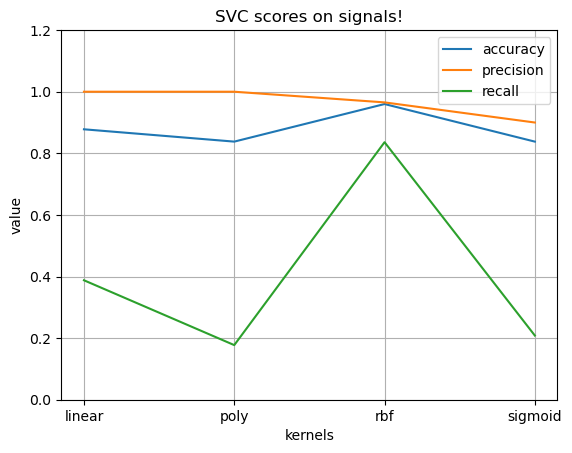

In [46]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
accuracy_list =[]; precision_list =[]; recall_list =[]

cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for which_kernel in kernels:
     model =SVC(kernel=which_kernel)
     accuracy_list.append(np.mean(cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)))
     precision_list.append(np.mean(cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)))
     recall_list.append(np.mean(cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)))

avg_score_list = []
for i in range (0, len(accuracy_list)):
    avg_score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)

best_kernel_index = avg_score_list.index(max(avg_score_list))
print('kernel of the max score : ', kernels[best_kernel_index], '\nmax score :', round(avg_score_list[best_kernel_index], 3))
print('accuracy:', round(accuracy_list[best_kernel_index], 2), ' precision:', round(precision_list[best_kernel_index], 2), \
    ' recall: ', round(recall_list[best_kernel_index], 2))

plt.xticks(np.arange(len(kernels)), tuple(kernels)) 
plt.plot(range(0, len(kernels)), accuracy_list, label = "accuracy")
plt.plot(range(0, len(kernels)), precision_list, label = "precision")
plt.plot(range(0, len(kernels)), recall_list, label = "recall")
plt.xlabel('kernels')
plt.ylabel('value')
plt.title('SVC scores on signals!')
plt.grid()
plt.legend()
plt.ylim(0, 1.2)
plt.show()



as you see, the best kernel according our weights by running SVC on signals is "rbf". 
# k-nearest neighbors(KNN)

In statistics, the k-nearest neighbors algorithm (k-NN) is a non-parametric supervised learning method first developed by Evelyn Fix and Joseph Hodges in 1951, and later expanded by Thomas Cover. It is used for classification and regression. In both cases, the input consists of the k closest training examples in a data set. The output depends on whether k-NN is used for classification or regression:

   - In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

   - In k-NN regression, the output is the property value for the object. This value is the average of the values of k nearest neighbors. If k = 1, then the output is simply assigned to the value of that single nearest neighbor.

k-NN is a type of classification where the function is only approximated locally and all computation is deferred until function evaluation. Since this algorithm relies on distance for classification, if the features represent different physical units or come in vastly different scales then normalizing the training data can improve its accuracy dramatically.

Both for classification and regression, a useful technique can be to assign weights to the contributions of the neighbors, so that the nearer neighbors contribute more to the average than the more distant ones. For example, a common weighting scheme consists in giving each neighbor a weight of 1/d, where d is the distance to the neighbor.

The neighbors are taken from a set of objects for which the class (for k-NN classification) or the object property value (for k-NN regression) is known. This can be thought of as the training set for the algorithm, though no explicit training step is required.

A peculiarity of the k-NN algorithm is that it is sensitive to the local structure of the data. 
[[ref](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)]


<div><img src="https://s31.picofile.com/file/8469162818/knn.gif" width="500"/></div>

just like the previous code block, we want to find the best value of model parameter. so we declare a for loop from *i=1* to *limit-1*. The rest are similar. 

n_neighbors of the max score :  1 
max score : 0.4582325378664051
accuracy: 0.89  precision: 1.0  recall:  0.46


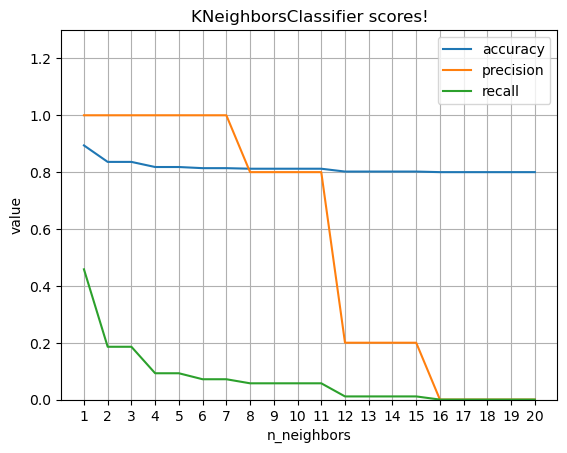

In [47]:
accuracy_list =[]; precision_list =[]; recall_list =[]
limit = 20
step = 1
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1, limit+1, step):
    model =KNeighborsClassifier(n_neighbors=i)
    accuracy_list.append(np.mean(cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision_list.append(np.mean(cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)))
    recall_list.append(np.mean(cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)))

score_list = []
for i in range (0, len(accuracy_list)):
    score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
best_Nneighbors_index = score_list.index(max(score_list))
print('n_neighbors of the max score : ', best_Nneighbors_index+1, '\nmax score :', score_list[best_Nneighbors_index])
print('accuracy:', round(accuracy_list[best_Nneighbors_index], 2), ' precision:', round(precision_list[best_Nneighbors_index], 2), \
    ' recall: ', round(recall_list[best_Nneighbors_index], 2))

plt.plot(range(1, limit+1, step), accuracy_list, label = "accuracy")
plt.plot(range(1, limit+1, step), precision_list, label = "precision")
plt.plot(range(1, limit+1, step), recall_list, label = "recall")
plt.xlabel('n_neighbors')
plt.ylabel('value')
plt.title('KNeighborsClassifier scores!')
plt.grid()
plt.legend()
plt.ylim(0, 1.3)
plt.xticks(range(1, limit+1, step)) 
plt.show()

as you can see, the best n_neighbors according our weights by running KNeighborsClassifier on signals is "1". 
# random forest on signals

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

It works in four steps:

1. Select random samples from a given dataset.
2. Construct a decision tree for each sample and get a prediction result from each decision tree.
3. Perform a vote for each predicted result.
4.  Select the prediction result with the most votes as the final prediction.

<div><img src="https://s31.picofile.com/file/8469162842/knn.png" width="500"/></div>

just like the previous code blocks, we want to find the best value of model's parameter. so we declare a for loop from *i=1* to *limit-1*. The rest are similar. 


n_estimators of the max score :  19 
max score : 0.8691952847559253
accuracy: 0.97  precision: 0.96  recall:  0.87


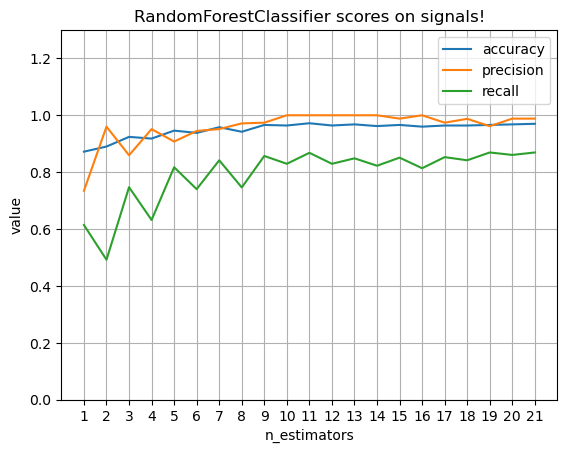

In [48]:
accuracy_list =[]; precision_list =[]; recall_list =[]
limit = 21
step = 1
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1, limit+1):
    model =RandomForestClassifier(random_state=seed, n_estimators=i)
    accuracy_list.append(np.mean(cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision_list.append(np.mean(cross_val_score(model, x, y, scoring='precision', cv=cv, n_jobs=-1)))
    recall_list.append(np.mean(cross_val_score(model, x, y, scoring='recall', cv=cv, n_jobs=-1)))
    

score_list = []
for i in range (0, len(accuracy_list)):
    score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
    
best_nestimators_index = score_list.index(max(score_list))
print('n_estimators of the max score : ', best_nestimators_index+1, '\nmax score :', score_list[best_nestimators_index])
print('accuracy:', round(accuracy_list[best_nestimators_index], 2), ' precision:', round(precision_list[best_nestimators_index], 2), \
    ' recall: ', round(recall_list[best_nestimators_index], 2))

plt.plot(range(1, limit+1, step), accuracy_list, label = "accuracy")
plt.plot(range(1, limit+1, step), precision_list, label = "precision")
plt.plot(range(1, limit+1, step), recall_list, label = "recall")
plt.xlabel('n_estimators')
plt.ylabel('value')
plt.title('RandomForestClassifier scores on signals!')
plt.grid()
plt.legend()
plt.ylim(0, 1.3)
plt.xticks(range(1, limit+1, step)) 
plt.show()

as you can see, the best n_estimators according our weights by running RandomForestClassifier on signals is "19". 
# Ploting Confusion Matrix

now that we have best parameters of each model, we plot their confusion matrix to see how they calculated the TP, TN, FP and FN. 

By using *k_fold.split(X=x, y=y)* on datas, we get the index of each fold and by using a for loop, we train and fit our model with them.

Also there's a function called *ConfusionMatrixDisplay* that display Confusion Matrix of  y_test and y_pred.

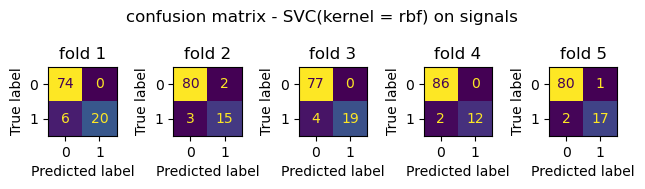

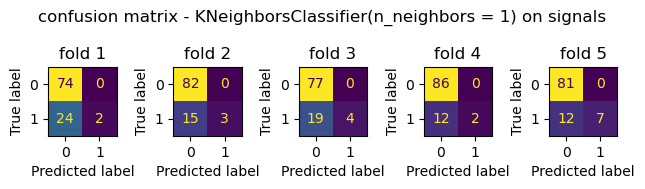

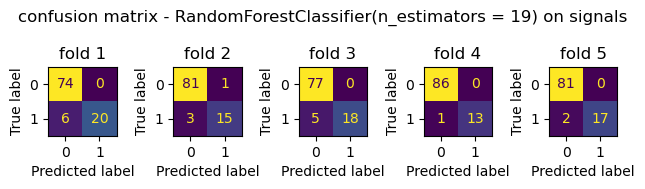

In [49]:
model =SVC(kernel=kernels[best_kernel_index])
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(1,5)
figure.tight_layout(pad=1.0)
for i in range(0, len(ax)): ax[i].set_title(f"fold {i+1}")
figure.suptitle(f'confusion matrix - SVC(kernel = {kernels[best_kernel_index]}) on signals')
plt.subplots_adjust(top=1.5)

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([x[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([x[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model.fit(X=x_train, y=y_train.ravel())
    y_pred = model.predict(x_test)

    cm = confusion_matrix( y_test,y_pred)
    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred), 
    display_labels = [0, 1]).plot(ax=ax[i], colorbar=False)
####################################################################3
model =KNeighborsClassifier(n_neighbors=(best_kernel_index+1))
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(1,5)
figure.tight_layout(pad=1.0)
for i in range(0, len(ax)): ax[i].set_title(f"fold {i+1}")
figure.suptitle(f'confusion matrix - KNeighborsClassifier(n_neighbors = {best_Nneighbors_index+1}) on signals')
plt.subplots_adjust(top=1.5)

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([x[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([x[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model.fit(X=x_train, y=y_train.ravel())
    y_pred = model.predict(x_test)

    cm = confusion_matrix( y_test,y_pred)
    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred), 
    display_labels = [0, 1]).plot(ax=ax[i], colorbar=False)
#######################################################################3
model =RandomForestClassifier(random_state=seed, n_estimators=best_nestimators_index)
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(1,5)
figure.tight_layout(pad=1.0)
for i in range(0, len(ax)): ax[i].set_title(f"fold {i+1}")
figure.suptitle(f'confusion matrix - RandomForestClassifier(n_estimators = {best_nestimators_index+1}) on signals')
plt.subplots_adjust(top=1.5)

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([x[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([x[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model.fit(X=x_train, y=y_train.ravel())
    y_pred = model.predict(x_test)

    cm = confusion_matrix( y_test,y_pred)
    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred), 
    display_labels = [0, 1]).plot(ax=ax[i], colorbar=False)

# ROC
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:
<div><img src="https://s31.picofile.com/file/8469162850/tpr.png" width="250"/></div>
False Positive Rate (FPR) is defined as follows:
<div><img src="https://s31.picofile.com/file/8469162876/fpr.png" width="250"/></div>

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve. [[ref](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)]

<div><img src="https://s30.picofile.com/file/8469162918/roc.png" width="400"/></div>

by using x_ax and y_ax we calculated the roc diagram of best models. according to curves, SVC and RF are better than KNN in our case.

roc_auc_score SVC :  1.0
roc_auc_score KNN :  0.75
roc_auc_score RF :  0.99
roc_auc_score SVC :  0.99
roc_auc_score KNN :  0.67
roc_auc_score RF :  1.0
roc_auc_score SVC :  1.0
roc_auc_score KNN :  0.76
roc_auc_score RF :  1.0
roc_auc_score SVC :  1.0
roc_auc_score KNN :  0.68
roc_auc_score RF :  1.0
roc_auc_score SVC :  1.0
roc_auc_score KNN :  0.82
roc_auc_score RF :  1.0


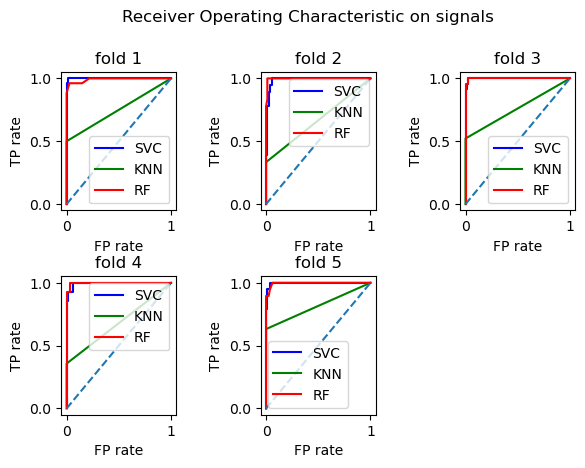

In [50]:
x_ax = [0, 0, 0, 1, 1]
y_ax = [0, 1, 2, 0, 1]

model_1 =SVC(kernel=kernels[best_kernel_index], probability=True)
model_2 =KNeighborsClassifier(n_neighbors=(best_kernel_index+1))
model_3 =RandomForestClassifier(random_state=seed, n_estimators=best_nestimators_index)

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(2, 3)
figure.tight_layout(pad=3)
figure.suptitle(f'Receiver Operating Characteristic on signals')
plt.subplots_adjust(top=0.85)
for i in range(0, 5): ax[x_ax[i], y_ax[i]].set_title(f"fold {i+1}")
ax[1,2].axis('off')

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([x[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([x[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model_1.fit(X=x_train, y=y_train.ravel())
    y_pred = model_1.predict_proba(x_test)
    y_pred=y_pred[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
    print('roc_auc_score SVC : ', round(roc_auc_score(y_test, y_pred), 2))
    ax[x_ax[i], y_ax[i]].plot(false_positive_rate1, true_positive_rate1, label = "SVC", color='b')

    model_2.fit(X=x_train, y=y_train.ravel())
    y_pred = model_2.predict_proba(x_test)
    y_pred=y_pred[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
    print('roc_auc_score KNN : ', round(roc_auc_score(y_test, y_pred), 2))
    ax[x_ax[i], y_ax[i]].plot(false_positive_rate1, true_positive_rate1, label = "KNN", color='g')

    model_3.fit(X=x_train, y=y_train.ravel())
    y_pred = model_3.predict_proba(x_test)
    y_pred=y_pred[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
    print('roc_auc_score RF : ', round(roc_auc_score(y_test, y_pred), 2))
    ax[x_ax[i], y_ax[i]].plot(false_positive_rate1, true_positive_rate1, label = "RF", color='r')
    
    ax[x_ax[i], y_ax[i]].legend()
    ax[x_ax[i], y_ax[i]].plot([0, 1], ls="--")
    ax[x_ax[i], y_ax[i]].set(xlabel='FP rate', ylabel='TP rate')

plt.show()

# SVC on features

after we ran our models with signals, it's time to use our features to run models.

we set *max_iter=10000000* because *default=-1* and it means no limit. but using linear as kernel will make model more complex and force it to overfit on datas. we avoid that by seting *max_iter=10000000*.


kernel of the max score :  linear 
max score : 0.718
accuracy: 0.62  precision: 0.64  recall:  0.72


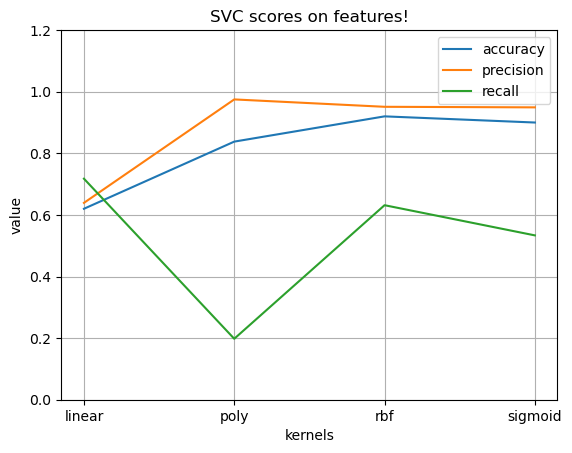

In [51]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
# kernels = ["poly", "rbf", "sigmoid"]
accuracy_list =[]; precision_list =[]; recall_list =[]

cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for i in kernels:
     model =SVC(kernel=i, max_iter=10000000)
     accuracy_list.append(np.mean(cross_val_score(model, features, y, scoring='accuracy', cv=cv, n_jobs=-1)))
     precision_list.append(np.mean(cross_val_score(model, features, y, scoring='precision', cv=cv, n_jobs=-1)))
     recall_list.append(np.mean(cross_val_score(model, features, y, scoring='recall', cv=cv, n_jobs=-1)))

score_list = []
for i in range (0, len(accuracy_list)):
    score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
best_kernel_index = score_list.index(max(score_list))
print('kernel of the max score : ', kernels[best_kernel_index], '\nmax score :', round(score_list[best_kernel_index], 3))
print('accuracy:', round(accuracy_list[best_kernel_index], 2), ' precision:', round(precision_list[best_kernel_index], 2), \
    ' recall: ', round(recall_list[best_kernel_index], 2))

x_pos = np.arange(len(kernels))
plt.xticks(x_pos, tuple(kernels)) 
plt.plot(range(0, len(kernels)), accuracy_list, label = "accuracy")
plt.plot(range(0, len(kernels)), precision_list, label = "precision")
plt.plot(range(0, len(kernels)), recall_list, label = "recall")
plt.xlabel('kernels')
plt.ylabel('value')
plt.title('SVC scores on features!')
plt.grid()
plt.legend()
plt.ylim(0, 1.2)
plt.show()

we set *max_iter=10000000* best kernel for SVC is linear.
# KNN on features

we run KNN on features: 

n_estimators of the max score :  3 
max score : 0.856497710273454
accuracy: 0.94  precision: 0.85  recall:  0.86


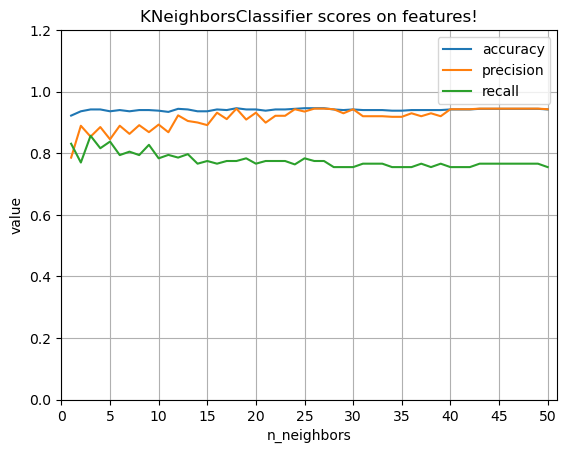

In [52]:
accuracy_list =[]; precision_list =[]; recall_list =[]
limit = 50
step = 1
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1, limit+1, step):
    model =KNeighborsClassifier(n_neighbors=i)
    accuracy_list.append(np.mean(cross_val_score(model, features, y, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision_list.append(np.mean(cross_val_score(model, features, y, scoring='precision', cv=cv, n_jobs=-1)))
    recall_list.append(np.mean(cross_val_score(model, features, y, scoring='recall', cv=cv, n_jobs=-1)))

score_list = []
for i in range (0, len(accuracy_list)):
    score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)

best_Nneighbors_index = score_list.index(max(score_list))
print('n_estimators of the max score : ', best_Nneighbors_index+1, '\nmax score :', score_list[best_Nneighbors_index])
print('accuracy:', round(accuracy_list[best_Nneighbors_index], 2), ' precision:', round(precision_list[best_Nneighbors_index], 2), \
    ' recall: ', round(recall_list[best_Nneighbors_index], 2))

plt.plot(range(1, limit+1, step), accuracy_list, label = "accuracy")
plt.plot(range(1, limit+1, step), precision_list, label = "precision")
plt.plot(range(1, limit+1, step), recall_list, label = "recall")

plt.xlabel('n_neighbors')
plt.ylabel('value')
plt.title('KNeighborsClassifier scores on features!')
plt.grid()
plt.legend()
plt.ylim(0, 1.2)
plt.xlim(0, limit+1)
plt.xticks(range(0, limit+1, 5*step))
plt.show()

the best n_neighbor for KNN with features is 3.
# RF on features

we run RF on features: 

n_estimators of the max score :  35 
max score : 0.9511077023662837
accuracy: 0.97  precision: 0.91  recall:  0.95


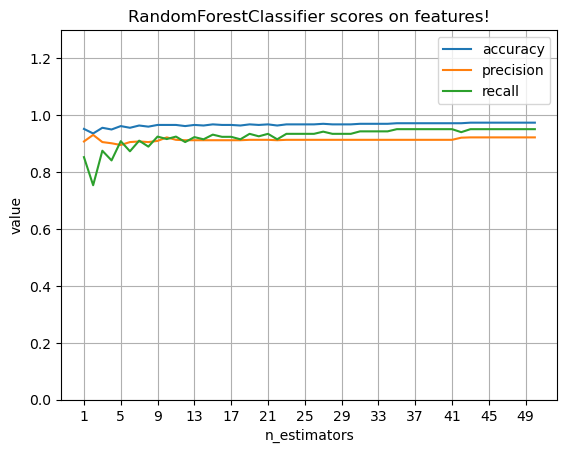

In [53]:
accuracy_list =[]; precision_list =[]; recall_list =[]
limit = 50
step = 1
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
for i in range(1, limit+1):
    model =RandomForestClassifier(random_state=seed, n_estimators=i)
    accuracy_list.append(np.mean(cross_val_score(model, features, y, scoring='accuracy', cv=cv, n_jobs=-1)))
    precision_list.append(np.mean(cross_val_score(model, features, y, scoring='precision', cv=cv, n_jobs=-1)))
    recall_list.append(np.mean(cross_val_score(model, features, y, scoring='recall', cv=cv, n_jobs=-1)))
    

score_list = []
for i in range (0, len(accuracy_list)):
    score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
    
best_nestimators_index = score_list.index(max(score_list))
print('n_estimators of the max score : ', best_nestimators_index+1, '\nmax score :', score_list[best_nestimators_index])
print('accuracy:', round(accuracy_list[best_nestimators_index], 2), ' precision:', round(precision_list[best_nestimators_index], 2), \
    ' recall: ', round(recall_list[best_nestimators_index], 2))

plt.plot(range(1, limit+1, step), accuracy_list, label = "accuracy")
plt.plot(range(1, limit+1, step), precision_list, label = "precision")
plt.plot(range(1, limit+1, step), recall_list, label = "recall")
plt.xlabel('n_estimators')
plt.ylabel('value')
plt.title('RandomForestClassifier scores on features!')
plt.grid()
plt.legend()
plt.ylim(0, 1.3)
plt.xticks(range(1, limit+1, 4)) 
plt.show()

# confusion matrix of models on features
just like the previous confusion matrix bloc, we plot confusion matrix for models with their best parameters. 

c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_ite

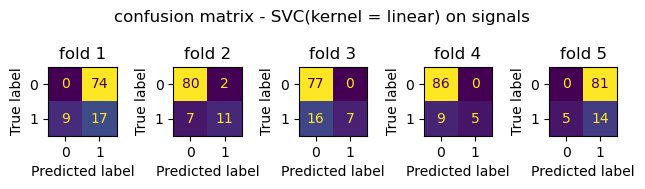

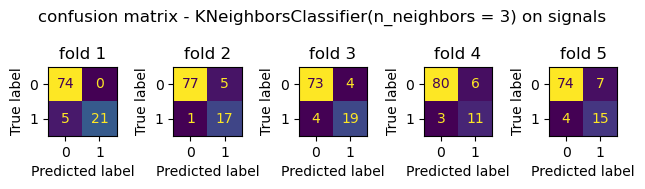

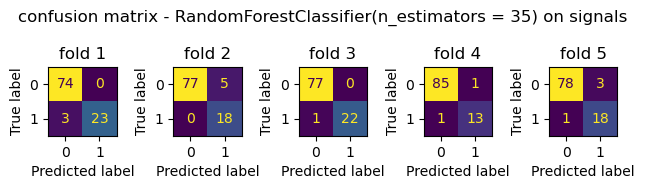

In [54]:
model =SVC(kernel=kernels[best_kernel_index], max_iter=100000)
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(1,5)
figure.tight_layout(pad=1.0)
for i in range(0, len(ax)): ax[i].set_title(f"fold {i+1}")
figure.suptitle(f'confusion matrix - SVC(kernel = {kernels[best_kernel_index]}) on signals')
plt.subplots_adjust(top=1.5)

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([features[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([features[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model.fit(X=x_train, y=y_train.ravel())
    y_pred = model.predict(x_test)

    cm = confusion_matrix( y_test,y_pred)
    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred), 
    display_labels = [0, 1]).plot(ax=ax[i], colorbar=False)
####################################################################3
model =KNeighborsClassifier(n_neighbors=(best_kernel_index+1))
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(1,5)
figure.tight_layout(pad=1.0)
for i in range(0, len(ax)): ax[i].set_title(f"fold {i+1}")
figure.suptitle(f'confusion matrix - KNeighborsClassifier(n_neighbors = {best_Nneighbors_index+1}) on signals')
plt.subplots_adjust(top=1.5)

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([features[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([features[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model.fit(X=x_train, y=y_train.ravel())
    y_pred = model.predict(x_test)

    cm = confusion_matrix( y_test,y_pred)
    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred), 
    display_labels = [0, 1]).plot(ax=ax[i], colorbar=False)
#######################################################################3
model =RandomForestClassifier(random_state=seed, n_estimators=best_nestimators_index)
k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(1,5)
figure.tight_layout(pad=1.0)
for i in range(0, len(ax)): ax[i].set_title(f"fold {i+1}")
figure.suptitle(f'confusion matrix - RandomForestClassifier(n_estimators = {best_nestimators_index+1}) on signals')
plt.subplots_adjust(top=1.5)

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([features[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([features[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model.fit(X=x_train, y=y_train.ravel())
    y_pred = model.predict(x_test)

    cm = confusion_matrix( y_test,y_pred)
    ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred), 
    display_labels = [0, 1]).plot(ax=ax[i], colorbar=False)

# ROC on features

so now it's time to see wich model is better on features using roc curves

c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


roc_auc_score SVC :  0.5
roc_auc_score KNN :  0.9
roc_auc_score RF :  0.98


c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


roc_auc_score SVC :  0.21
roc_auc_score KNN :  0.97
roc_auc_score RF :  0.99


c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


roc_auc_score SVC :  0.01
roc_auc_score KNN :  0.95
roc_auc_score RF :  1.0


c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


roc_auc_score SVC :  0.01
roc_auc_score KNN :  0.94
roc_auc_score RF :  0.99


c:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


roc_auc_score SVC :  0.61
roc_auc_score KNN :  0.93
roc_auc_score RF :  0.99


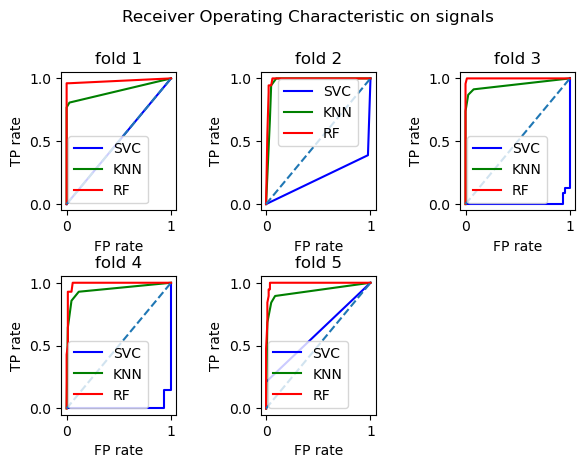

In [55]:
x_ax = [0, 0, 0, 1, 1]
y_ax = [0, 1, 2, 0, 1]

model_1 =SVC(kernel=kernels[best_kernel_index], probability=True, max_iter=100000)
model_2 =KNeighborsClassifier(n_neighbors=(best_Nneighbors_index+1))
model_3 =RandomForestClassifier(random_state=seed, n_estimators=best_nestimators_index)

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

figure, ax = plt.subplots(2, 3)
figure.tight_layout(pad=3)
figure.suptitle(f'Receiver Operating Characteristic on signals')
plt.subplots_adjust(top=0.85)
for i in range(0, 5): ax[x_ax[i], y_ax[i]].set_title(f"fold {i+1}")
ax[1,2].axis('off')

for i, (train_index, test_index) in enumerate(k_fold.split(X=x, y=y)):
    x_train = np.array([features[feat, :] for feat in train_index], dtype=float)
    y_train = np.array([y[target] for target in train_index], dtype=float)
    x_test = np.array([features[feat, :] for feat in test_index], dtype=float)
    y_test = np.array([y[target] for target in test_index], dtype=float)
    
    model_1.fit(X=x_train, y=y_train.ravel())
    y_pred = model_1.predict_proba(x_test)
    y_pred=y_pred[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
    print('roc_auc_score SVC : ', round(roc_auc_score(y_test, y_pred), 2))
    ax[x_ax[i], y_ax[i]].plot(false_positive_rate1, true_positive_rate1, label = "SVC", color='b')

    model_2.fit(X=x_train, y=y_train.ravel())
    y_pred = model_2.predict_proba(x_test)
    y_pred=y_pred[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
    print('roc_auc_score KNN : ', round(roc_auc_score(y_test, y_pred), 2))
    ax[x_ax[i], y_ax[i]].plot(false_positive_rate1, true_positive_rate1, label = "KNN", color='g')

    model_3.fit(X=x_train, y=y_train.ravel())
    y_pred = model_3.predict_proba(x_test)
    y_pred=y_pred[:,1]
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_pred)
    print('roc_auc_score RF : ', round(roc_auc_score(y_test, y_pred), 2))
    ax[x_ax[i], y_ax[i]].plot(false_positive_rate1, true_positive_rate1, label = "RF", color='r')
    
    ax[x_ax[i], y_ax[i]].legend()
    ax[x_ax[i], y_ax[i]].plot([0, 1], ls="--")
    ax[x_ax[i], y_ax[i]].set(xlabel='FP rate', ylabel='TP rate')

plt.show()

# Normalization on features
 the goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different ranges.

### Standardization (Standard Scalar) :

standardization (or Z-score normalization) means centering the variable at zero and standardizing the variance at 1. The procedure involves subtracting the mean of each observation and then dividing by the standard deviation:

The result of standardization is that the features will be rescaled so that they’ll have the properties of a standard normal distribution with
*μ=0* and *σ=1*

where μ is the mean (average) and σ is the standard deviation from the mean.

### Normalization (Min-Max Scalar) :
n this approach, the data is scaled to a fixed range — usually 0 to 1.
In contrast to standardization, the cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers. Thus MinMax Scalar is sensitive to outliers.

A Min-Max scaling is typically done via the following equation:
<div><img src="https://s31.picofile.com/file/8469162942/minmax.png" width="400"/></div>

Robust Scalar (Scaling to median and quantiles) :

Scaling using median and quantiles consists of subtracting the median to all the observations and then dividing by the interquartile difference. It Scales features using statistics that are robust to outliers.

The interquartile difference is the difference between the 75th and 25th quantile:

*IQR = 75th quantile — 25th quantile*

The equation to calculate scaled values:

*X_scaled = (X — X.median) / IQR*
[[ref](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)]

In [56]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


normal_features = []

scaler = StandardScaler() 
features_StandardScaler_row = np.zeros_like(features)
features_StandardScaler_col = np.zeros_like(features)
for i in range(len(features)):features_StandardScaler_row[i] = scaler.fit_transform(features[i].reshape(-1, 1)).flatten()
for i in range(len(features[0])):features_StandardScaler_col[:, i] = scaler.fit_transform(features[:, i].reshape(-1, 1)).flatten()

scaler = MinMaxScaler() 
features_MinMaxScaler_row = np.zeros_like(features)
features_MinMaxScaler_col = np.zeros_like(features)
for i in range(len(features)):features_MinMaxScaler_row[i] = scaler.fit_transform(features[i].reshape(-1, 1)).flatten()
for i in range(len(features[0])):features_MinMaxScaler_col[:, i] = scaler.fit_transform(features[:, i].reshape(-1, 1)).flatten()



scaler = RobustScaler() 
features_RobustScaler_row = np.zeros_like(features)
features_RobustScaler_col = np.zeros_like(features)
for i in range(len(features)):features_RobustScaler_row[i] = scaler.fit_transform(features[i].reshape(-1, 1)).flatten()
for i in range(len(features[0])):features_RobustScaler_col[:, i] = scaler.fit_transform(features[:, i].reshape(-1, 1)).flatten()

normal_features = [features_StandardScaler_row, features_StandardScaler_col, \
                      features_MinMaxScaler_row,   features_MinMaxScaler_col, \
                      features_RobustScaler_row,   features_RobustScaler_col]
normal_features_name = ["features_StandardScaler_row", "features_StandardScaler_col", \
                      "features_MinMaxScaler_row",   "features_MinMaxScaler_col", \
                      "features_RobustScaler_row",   "features_RobustScaler_col"]

# Normalization on columns or rows
to understand that should we use normalization on rows or colomn of features, we test both and plot them to see what will happen.

n_neighbors of the max score :  3 max score : 0.8753011290768729
accuracy: 0.8  precision: 0.0  recall:  0.0
n_neighbors of the max score :  3 max score : 0.8753011290768729
accuracy: 0.97  precision: 0.94  recall:  0.89
n_neighbors of the max score :  3 max score : 0.8753011290768729
accuracy: 0.8  precision: 0.0  recall:  0.0
n_neighbors of the max score :  3 max score : 0.8753011290768729
accuracy: 0.96  precision: 0.94  recall:  0.87
n_neighbors of the max score :  3 max score : 0.8753011290768729
accuracy: 0.15  precision: 0.15  recall:  0.73
n_neighbors of the max score :  3 max score : 0.8753011290768729
accuracy: 0.51  precision: 0.4  recall:  0.79


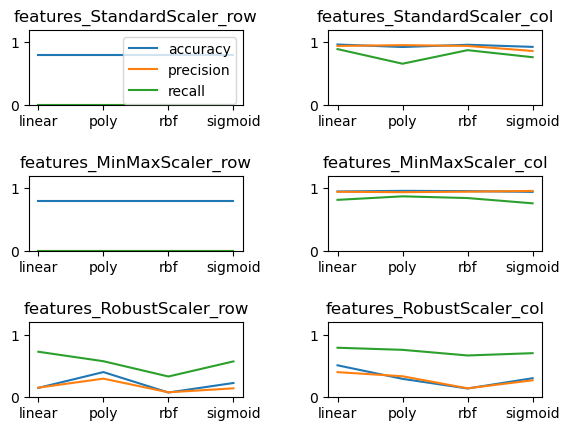

In [57]:
normal_features = [features_StandardScaler_row, features_StandardScaler_col, \
                      features_MinMaxScaler_row,   features_MinMaxScaler_col, \
                      features_RobustScaler_row,   features_RobustScaler_col]
normal_features_name = ["features_StandardScaler_row", "features_StandardScaler_col", \
                      "features_MinMaxScaler_row",   "features_MinMaxScaler_col", \
                      "features_RobustScaler_row",   "features_RobustScaler_col"]
                      
kernels = ["linear", "poly", "rbf", "sigmoid"]
max_iter_list = [-1, -1, -1, -1, 10, 10]
x_ax_list = [0, 0, 1, 1, 2, 2]
y_ax_list = [0, 1, 0, 1, 0, 1]

figure, axis = plt.subplots(3, 2)
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
figure.tight_layout(pad=3)
# plt.subplots_adjust(top=0.85)
# axis.set_ylim(left=0, right=1.2)
for pointer in range(0, len(axis.flatten())):

    accuracy_list =[]; precision_list =[]; recall_list =[]
    for which_kernel in kernels:
        model =SVC(kernel=which_kernel, max_iter=max_iter_list[pointer])
        accuracy_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='accuracy', cv=cv, n_jobs=-1)))
        precision_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='precision', cv=cv, n_jobs=-1)))
        recall_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='recall', cv=cv, n_jobs=-1)))
    avg_score_list = []
    for i in range (0, len(accuracy_list)):
        avg_score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
    best_kernel_index = avg_score_list.index(max(avg_score_list))
    print('n_neighbors of the max score : ', best_Nneighbors_index+1, 'max score :', score_list[best_Nneighbors_index])
    print('accuracy:', round(accuracy_list[best_kernel_index], 2), ' precision:', round(precision_list[best_kernel_index], 2), \
        ' recall: ', round(recall_list[best_kernel_index], 2))

    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(0, len(kernels)), accuracy_list, label = "accuracy")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(0, len(kernels)), precision_list, label = "precision")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(0, len(kernels)), recall_list, label = "recall")
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_xticks(np.arange(len(kernels)), tuple(kernels))
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_title(normal_features_name[pointer])
    if(pointer==0):axis[x_ax_list[pointer], y_ax_list[pointer]].legend()
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_ylim((0, 1.2))
plt.show()

as you can see, normalization on rows doesn't work properly but on colomns, gives us a new features that can be run into models

### how much SVC became better with Normalization 

so let's check how much our models got better with normalized data.

kernel of the max score :  poly   max score : 0.989
accuracy: 0.2  precision: 0.2  recall:  0.99
kernel of the max score :  linear   max score : 0.893
accuracy: 0.97  precision: 0.94  recall:  0.89
kernel of the max score :  poly   max score : 0.989
accuracy: 0.2  precision: 0.2  recall:  0.99
kernel of the max score :  poly   max score : 0.875
accuracy: 0.96  precision: 0.94  recall:  0.87
kernel of the max score :  poly   max score : 0.989
accuracy: 0.2  precision: 0.2  recall:  0.99
kernel of the max score :  linear   max score : 0.79
accuracy: 0.51  precision: 0.4  recall:  0.79


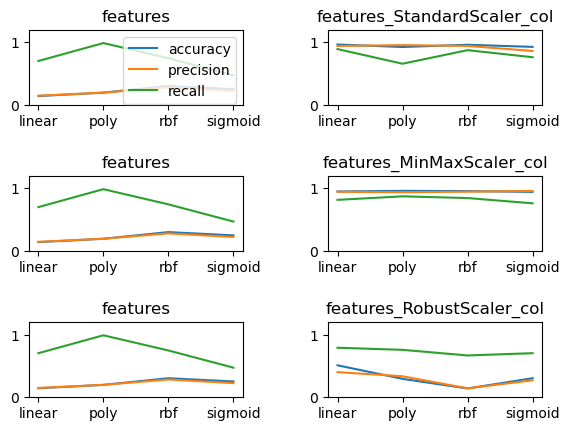

In [58]:
normal_features = [features, features_StandardScaler_col, \
                      features,   features_MinMaxScaler_col, \
                      features,   features_RobustScaler_col]
normal_features_name = ["features", "features_StandardScaler_col", \
                      "features",   "features_MinMaxScaler_col", \
                      "features",   "features_RobustScaler_col"]

kernels = ["linear", "poly", "rbf", "sigmoid"]
max_iter_list = [10, -1, 10, -1, 10, 10]
x_ax_list = [0, 0, 1, 1, 2, 2]
y_ax_list = [0, 1, 0, 1, 0, 1]

figure, axis = plt.subplots(3, 2)
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
figure.tight_layout(pad=3)
for pointer in range(0, len(axis.flatten())):

    accuracy_list =[]; precision_list =[]; recall_list =[]
    for which_kernel in kernels:
        model =SVC(kernel=which_kernel, max_iter=max_iter_list[pointer])
        accuracy_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='accuracy', cv=cv, n_jobs=-1)))
        precision_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='precision', cv=cv, n_jobs=-1)))
        recall_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='recall', cv=cv, n_jobs=-1)))
    avg_score_list = []
    for i in range (0, len(accuracy_list)):
        avg_score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
    best_kernel_index = avg_score_list.index(max(avg_score_list))
    print('kernel of the max score : ', kernels[best_kernel_index], '  max score :', round(avg_score_list[best_kernel_index], 3))
    print('accuracy:', round(accuracy_list[best_kernel_index], 2), ' precision:', round(precision_list[best_kernel_index], 2), \
        ' recall: ', round(recall_list[best_kernel_index], 2))

    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(0, len(kernels)), accuracy_list, label = "accuracy")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(0, len(kernels)), precision_list, label = "precision")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(0, len(kernels)), recall_list, label = "recall")
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_xticks(np.arange(len(kernels)), tuple(kernels))
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_title(normal_features_name[pointer])
    if(pointer==0):axis[x_ax_list[pointer], y_ax_list[pointer]].legend()
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_ylim((0, 1.2))
plt.show()

as you can see StandardScaler make SVC works a little better than unnormalized datae but MinMaxScaler and RobustScaler make models worse.

# how much RF became better with Normalization 

n_estimators of the max score :  19   max score : 0.934719742500063
accuracy: 0.97  precision: 0.91  recall:  0.93
n_estimators of the max score :  19   max score : 0.934719742500063
accuracy: 0.97  precision: 0.91  recall:  0.93
n_estimators of the max score :  19   max score : 0.934719742500063
accuracy: 0.97  precision: 0.91  recall:  0.93
n_estimators of the max score :  19   max score : 0.934719742500063
accuracy: 0.97  precision: 0.91  recall:  0.93
n_estimators of the max score :  19   max score : 0.934719742500063
accuracy: 0.97  precision: 0.91  recall:  0.93
n_estimators of the max score :  19   max score : 0.934719742500063
accuracy: 0.97  precision: 0.91  recall:  0.93


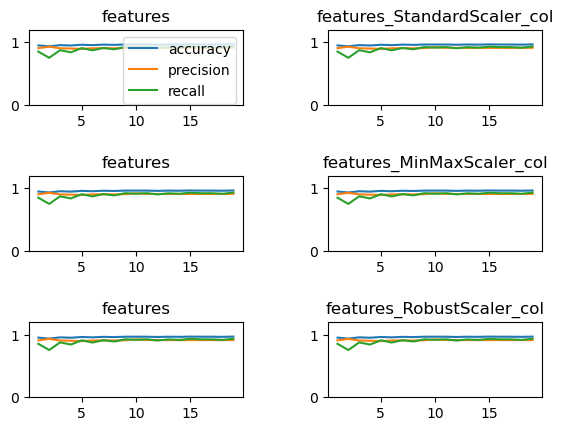

In [59]:
normal_features = [features, features_StandardScaler_col, \
                      features,   features_MinMaxScaler_col, \
                      features,   features_RobustScaler_col]
normal_features_name = ["features", "features_StandardScaler_col", \
                      "features",   "features_MinMaxScaler_col", \
                      "features",   "features_RobustScaler_col"]


nestimators_limit = 20
x_ax_list = [0, 0, 1, 1, 2, 2]
y_ax_list = [0, 1, 0, 1, 0, 1]

figure, axis = plt.subplots(3, 2)
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
figure.tight_layout(pad=3)
for pointer in range(0, len(axis.flatten())):
    accuracy_list =[]; precision_list =[]; recall_list =[]
    for nestimator_number in range(1, nestimators_limit):
        model =RandomForestClassifier(random_state=seed, n_estimators=nestimator_number)
        accuracy_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='accuracy', cv=cv, n_jobs=-1)))
        precision_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='precision', cv=cv, n_jobs=-1)))
        recall_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='recall', cv=cv, n_jobs=-1)))
    avg_score_list = []
    for i in range (0, len(accuracy_list)):
        avg_score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
    best_nestimators_index = avg_score_list.index(max(avg_score_list))
    print('n_estimators of the max score : ', best_nestimators_index+1, '  max score :', avg_score_list[best_nestimators_index])
    print('accuracy:', round(accuracy_list[best_nestimators_index], 2), ' precision:', round(precision_list[best_nestimators_index], 2), \
        ' recall: ', round(recall_list[best_nestimators_index], 2))

    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(1, nestimators_limit), accuracy_list, label = "accuracy")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(1, nestimators_limit), precision_list, label = "precision")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(1, nestimators_limit), recall_list, label = "recall")
    # axis[x_ax_list[pointer], y_ax_list[pointer]].set_xticks(np.arange(len(kernels)), tuple(kernels))
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_title(normal_features_name[pointer])
    if(pointer==0):axis[x_ax_list[pointer], y_ax_list[pointer]].legend()
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_ylim((0, 1.2))
plt.show()

so there is no Difference between unnormalized and normalized datas RF.

n_estimators of the max score :  3   max score : 0.856497710273454
accuracy: 0.94  precision: 0.85  recall:  0.86
n_estimators of the max score :  1   max score : 0.9053900079071703
accuracy: 0.97  precision: 0.94  recall:  0.91
n_estimators of the max score :  3   max score : 0.856497710273454
accuracy: 0.94  precision: 0.85  recall:  0.86
n_estimators of the max score :  1   max score : 0.9057306029846075
accuracy: 0.97  precision: 0.94  recall:  0.91
n_estimators of the max score :  3   max score : 0.856497710273454
accuracy: 0.94  precision: 0.85  recall:  0.86
n_estimators of the max score :  1   max score : 0.8868307893479518
accuracy: 0.96  precision: 0.91  recall:  0.89


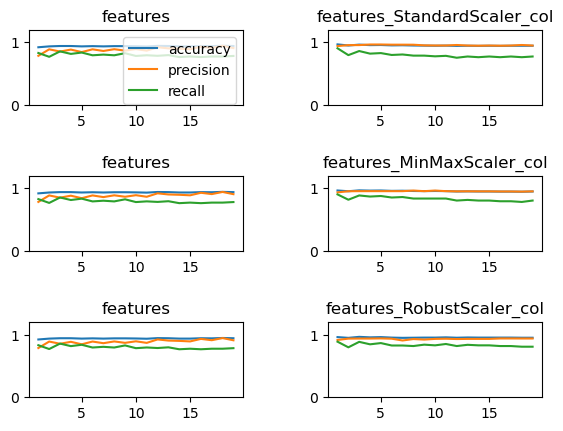

In [60]:
normal_features = [features, features_StandardScaler_col, \
                      features,   features_MinMaxScaler_col, \
                      features,   features_RobustScaler_col]
normal_features_name = ["features", "features_StandardScaler_col", \
                      "features",   "features_MinMaxScaler_col", \
                      "features",   "features_RobustScaler_col"]


n_neighbor_limit = 20
x_ax_list = [0, 0, 1, 1, 2, 2]
y_ax_list = [0, 1, 0, 1, 0, 1]

figure, axis = plt.subplots(3, 2)
cv = KFold(n_splits=5, random_state=seed, shuffle=True)
figure.tight_layout(pad=3)
for pointer in range(0, len(axis.flatten())):
    accuracy_list =[]; precision_list =[]; recall_list =[]
    for n_neighbornumber in range(1, n_neighbor_limit):
        # model =RandomForestClassifier(random_state=seed, n_estimators=nestimator_number)
        model =KNeighborsClassifier(n_neighbors=(n_neighbornumber))
        accuracy_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='accuracy', cv=cv, n_jobs=-1)))
        precision_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='precision', cv=cv, n_jobs=-1)))
        recall_list.append(np.mean(cross_val_score(model, normal_features[pointer], y, scoring='recall', cv=cv, n_jobs=-1)))
    avg_score_list = []
    for i in range (0, len(accuracy_list)):
        avg_score_list.append((accuracy_W*accuracy_list[i] + precision_w*precision_list[i] + recall_w*recall_list[i])/sum_w)
    best_Nneighbors_index = avg_score_list.index(max(avg_score_list))
    print('n_estimators of the max score : ', best_Nneighbors_index+1, '  max score :', avg_score_list[best_Nneighbors_index])
    print('accuracy:', round(accuracy_list[best_Nneighbors_index], 2), ' precision:', round(precision_list[best_Nneighbors_index], 2), \
        ' recall: ', round(recall_list[best_Nneighbors_index], 2))

    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(1, nestimators_limit), accuracy_list, label = "accuracy")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(1, nestimators_limit), precision_list, label = "precision")
    axis[x_ax_list[pointer], y_ax_list[pointer]].plot(range(1, nestimators_limit), recall_list, label = "recall")
    # axis[x_ax_list[pointer], y_ax_list[pointer]].set_xticks(np.arange(len(kernels)), tuple(kernels))
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_title(normal_features_name[pointer])
    if(pointer==0):axis[x_ax_list[pointer], y_ax_list[pointer]].legend()
    axis[x_ax_list[pointer], y_ax_list[pointer]].set_ylim((0, 1.2))
plt.show()

so normalization malkes KNN works much better than unnormalized data. 